# For 1 percent data with 1000 points we are taking a dnn driven trajectory


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import sklearn 
from keras.layers import Dense
from keras.models import Sequential
import os
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/home/saichaitanya/Chaitanya/CSV files/1000 points per trajectory/May10rd1percent_RLV_data 1000 points.csv',header = None,names = ['h','v','s','omega','gamma','m','theta','Thrust','beta','time'])
input = output =df.values
X = input[:,0:7]
y = output[:,7:9]
# Individual Data
from sklearn import preprocessing
X_norm = preprocessing.minmax_scale(X)
y_norm = preprocessing.minmax_scale(y)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.1, random_state=42)
X_val = X_train[-10000:]
y_val = y_train[-10000:]
X_train = X_train[:-10000]
y_train = y_train[:-10000]

In [3]:
def create_model2(n):
    model = Sequential()
    model.add(Dense(n,input_shape=(7,),kernel_initializer='uniform'))
    model.add(Dense(n,kernel_initializer='uniform',activation = 'relu'))
    model.add(Dense(n,kernel_initializer='uniform',activation = 'relu')) # since tanh has more nonlinearity we add it here, it also gives -ve values so , some layers which are not necessary will lead to 0 in next layer
    model.add(Dense(n,kernel_initializer='uniform',activation = 'relu'))
    model.add(Dense(n,kernel_initializer='uniform',activation = 'relu'))
    model.add(Dense(2,kernel_initializer='uniform',activation = 'sigmoid'))
    return model

In [4]:
i = 7;
model = create_model2(2**i)
path_Of_model =f"/home/saichaitanya/Chaitanya/GOOGLE COLAB  DOCS/1new percent variation/1000 points 7 states and 2 op with val_set having 128 neurons and batchsize 256/cp.ckpt"
model.load_weights(path_Of_model)

2022-05-22 09:29:02.036370: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-05-22 09:29:02.036429: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-05-22 09:29:02.038721: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.mean_squared_error
model.compile(optimizer=opt,loss=loss,metrics='accuracy')
# loss,accuracy = model.evaluate(X_norm,y_norm)

# Values for DNN driven trajectory

In [6]:
import math

In [7]:
R0 = 6378*1000;
g0=9.81
Cd = 0.5
S_ref =10.75
Isp =300;
I_z = 3346393
l_com = 9.778
t_ref = 32
h0=5000;
v0=325;
s0=850;
## The inputs and outputs which varied have values in decimals 
## rest all have been rounded off to 5-6 digits
omega0= 0.342
theta0= round(-75*math.pi/180,4)
gamma0= round(-75*math.pi/180,4) #
m0= round(26229.667,0) # our values of mass are rounded of when taking data
r0 = h0+637800

max(df.h.values)

df.loc[df['s']==850]

## Here we are finding the trajectory which relates to the given input conditions

In [8]:
# First we find the index of the row where we have the given initial conditions, we validate if we had 
# taken the correct trajectory for that we need to check the ending values of s such that s = s0.
idx = df.loc[(df['h'] == h0) & (df['v'] == v0)]
idx = np.array(idx.index.astype(int))
def trajectory_finding(idx,df,s0):
    # we have 3003 points for getting full trajectory starting from index 0-3002
    for i in range(idx.shape[0]):
        df2= df[idx[0]+3003*i:idx[0]+3003*(i+1)]
        if (df2.s.values[3002]==s0):
            break
        else:
            continue
    return np.array([df2.index[0],df2.index[3002]])

In [9]:
idx_i,idx_f = trajectory_finding(idx,df,s0)

In [10]:
## Normalizing the inputs
def norm_inputs(a,b):
    return (a-min(b))/(max(b)-min(b))

In [11]:
h = X[:,0];
v = X[:,1];
s = X[:,2];
omega = X[:,3]
gamma= X[:,4]
m = X[:,5]
theta = X[:,6]
T = y[:,0]
b = y[:,1]
r = 637800+h

In [12]:
h_norm = norm_inputs(h,h)
v_norm= norm_inputs(v,v)
s_norm= norm_inputs(s,s)
omega_norm= norm_inputs(omega,omega)
gamma_norm= norm_inputs(gamma,gamma)
m_norm= norm_inputs(m,m)
theta_norm= norm_inputs(theta,theta)
r_norm = norm_inputs(r,r)
T_norm = norm_inputs(T,T)
b_norm = norm_inputs(b,b)

In [13]:
h1 = norm_inputs(h0,h)
v1= norm_inputs(v0,v)
s1= norm_inputs(s0,s)
omega1= norm_inputs(omega0,omega)
gamma1= norm_inputs(gamma0,gamma)
m1= norm_inputs(m0,m)
theta1= norm_inputs(theta0,theta)
r1 = norm_inputs(r0,r)

In [14]:
math.pi/180

0.017453292519943295

In [16]:
# For this trajectory we are creating a vector of Neural Network inputs and obtain the Thrust, beta predicted values.
# given all the 7 states as input. and these controls will be sent to the DNN driven trajectory generation model
# ip_traj = df.all
# normalize the inputs and ouputs for observation
data_norm = np.array([h_norm,v_norm,s_norm,omega_norm,gamma_norm,m_norm,theta_norm,T_norm,b_norm]).T
df_norm = pd.DataFrame(data_norm,columns=['h','v','s','omega','gamma','m','theta','Thrust','beta'])

# Trajectory for the given initial condition:
data_traj = df_norm.values[idx_i:idx_f+1][:,0:9]
ip_traj = data_traj[:,0:7]
op_traj = data_traj[:,7:9]

# Intermediate trajectories averaged initial guess 

In [17]:
## Intermediate trajectory values:
ip_mid = [];
op_mid = [];
for i in range(len(ip_traj)-1):
     ip_mid = np.append(ip_mid,(ip_traj[i,:]+ip_traj[i+1,:])/2)
     op_mid = np.append(op_mid,(op_traj[i,:]+op_traj[i+1,:])/2)
        
ip_mid = ip_mid.reshape(len(ip_traj)-1,7)
op_mid = op_mid.reshape(len(ip_traj)-1,2)

In [18]:
"""
h_traj = np.where(h1==h_norm)
v_traj = np.where(v1==v_norm)
s_traj = np.where(s1==s_norm)
omega_traj = np.where(omega1==omega_norm)
gamma_traj = np.where(gamma1 == gamma_norm)
m_traj = np.where(m1==m_norm)
theta_traj=np.where(theta1==theta_norm)
# T_traj=np.where(T1==T_norm)
# b_traj=np.where(b1==b_norm)
"""

'\nh_traj = np.where(h1==h_norm)\nv_traj = np.where(v1==v_norm)\ns_traj = np.where(s1==s_norm)\nomega_traj = np.where(omega1==omega_norm)\ngamma_traj = np.where(gamma1 == gamma_norm)\nm_traj = np.where(m1==m_norm)\ntheta_traj=np.where(theta1==theta_norm)\n# T_traj=np.where(T1==T_norm)\n# b_traj=np.where(b1==b_norm)\n'

    average_intermediate_values= [];
    n = int(X.shape[0]/3003)
    for i in range(n):
        average_intermediate_values = np.append(average_intermediate_values,(df.values[i*3003,:]- df.values[i*3003+1,:]))
        average_intermediate_values = average_intermediate_values.reshape(n,10)
    ip_mean = np.mean(average_intermediate_values,0)
    ip = np.array([h1,v1,s1,omega1,gamma1,m1,theta1]).reshape(1,7)
    T1,b1 = np.squeeze(model.predict(ip))

## Now we need to append the values for all state variables in DNN driven trajectory and then we need to antinormalize the outputs to validate with the actual trajectory.

In [19]:
def AntiNorm(Norm_value,actual):
  return (max(actual)-min(actual))*Norm_value+min(actual)

AntiNorm(T,T)
AntiNorm(b,b)


array([-0.17027757, -0.170684  , -0.17105892, ..., -0.18897457,
       -0.18897227, -0.18897   ])

## Defining variables which will be appended as the iterations progress in RK4 method:

In [31]:
X_norm

array([[9.89970559e-01, 9.89864139e-01, 6.31909006e-09, ...,
        5.44715447e-01, 1.00000000e+00, 6.27155523e-01],
       [9.88597481e-01, 9.88340651e-01, 2.14239237e-03, ...,
        5.44383607e-01, 9.99143469e-01, 6.30905332e-01],
       [9.87224403e-01, 9.86848254e-01, 4.27968741e-03, ...,
        5.43885847e-01, 9.98286938e-01, 6.34605801e-01],
       ...,
       [3.63616979e-06, 1.33693872e-04, 9.88441112e-01, ...,
        1.10336818e-01, 1.11349036e-01, 4.97984478e-01],
       [2.35654050e-06, 6.71578517e-05, 9.88441112e-01, ...,
        1.10336818e-01, 1.11349036e-01, 4.97984478e-01],
       [1.08226502e-06, 9.32747941e-07, 9.88441112e-01, ...,
        1.10336818e-01, 1.11134904e-01, 4.97984478e-01]])

In [32]:
y_norm

array([[0.28605627, 0.62777485],
       [0.2820922 , 0.62495257],
       [0.27828258, 0.622349  ],
       ...,
       [0.55836701, 0.49793917],
       [0.55823831, 0.49795512],
       [0.5581096 , 0.49797091]])

In [33]:
pred = model.predict(X_norm)

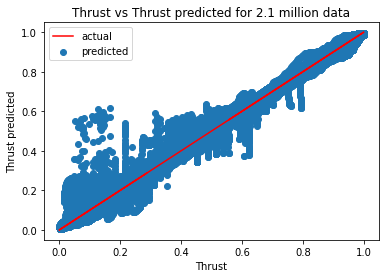

In [67]:
plt.scatter(y_norm[:,0],pred[:,0])
plt.plot(y_norm[:,0],y_norm[:,0],color = 'red')
plt.xlabel("Thrust")
plt.ylabel("Thrust predicted")
plt.legend(['actual','predicted'])
plt.title("Thrust vs Thrust predicted for 2.1 million data")
plt.savefig("8.1.png")

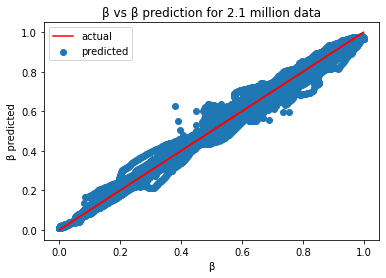

In [68]:
plt.scatter(y_norm[:,1],pred[:,1])
plt.plot(y_norm[:,1],y_norm[:,1],color = 'red')
plt.xlabel("β")
plt.ylabel("β predicted")
plt.legend(['actual','predicted'])
plt.title("β vs β prediction for 2.1 million data")
plt.savefig("8.2.png")

In [120]:
i=720

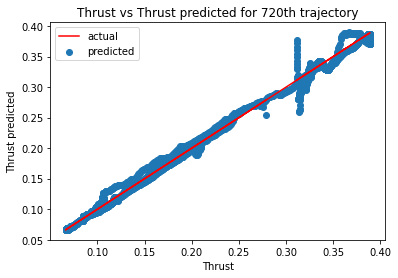

In [121]:
plt.plot(y_norm[:,0][0+3003*i:3003*(i+1)],y_norm[:,0][0+3003*i:3003*(i+1)],color = 'red')
plt.scatter(y_norm[:,0][0+3003*i:3003*(i+1)],pred[:,0][0+3003*i:3003*(i+1)])
plt.xlabel("Thrust")
plt.ylabel("Thrust predicted")
plt.legend(['actual','predicted'])
plt.title(f"Thrust vs Thrust predicted for {i}th trajectory")
plt.savefig(f"8.30{i}.png")

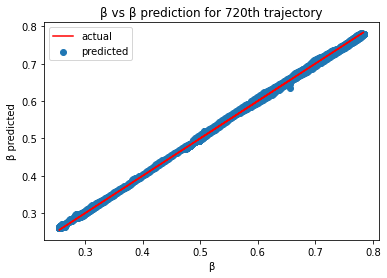

In [122]:
plt.scatter(y_norm[:,1][0+3003*i:3003*(i+1)],pred[:,1][0+3003*i:3003*(i+1)])
plt.plot(y_norm[:,1][0+3003*i:3003*(i+1)],y_norm[:,1][0+3003*i:3003*(i+1)],color = 'red')
plt.xlabel("β")
plt.ylabel("β predicted")
plt.legend(['actual','predicted'])
plt.title(f"β vs β prediction for {i}th trajectory")
plt.savefig(f"8.40{i}.png")

In [20]:
# local variables within the DNN function
ω2 = [];
θ2 = [];
v2 = [];
γ2 = [];
r2 = [];
s2 = [];
h2 = [];

In [21]:
# global variables for appending
ω_dnn = [];
θ_dnn = [];
v_dnn = [];
γ_dnn = [];
r_dnn = [];
s_dnn = [];
h_dnn = [];

In [26]:
model.evaluate(X_test,y_test)

6842/6842 [==============================] - 9s 1ms/step - loss: 3.9799e-05 - accuracy: 0.9963


[3.979882603744045e-05, 0.996272623538971]

In [25]:
model.predict(np.array([h1,v1,s1,omega1,gamma1,m1,theta1]).reshape(1,7))

array([[1.7029949e-08, 1.2901937e-09]], dtype=float32)

h_dnn=5
for _ in range(5):
    h_dnn = np.append(h_dnn,_)
    h_dnn
h_dnn

In [286]:
ip = np.array([h1,v1,s1,omega1,gamma1,m1,theta1]).reshape(1,7)
ip_int = ip_mid[0,:]
op_int = op_mid[0,:]

In [287]:
T1,b1 = np.squeeze(model.predict(ip))
T1_int,b1_int = np.squeeze(model.predict(ip_int.reshape(1,7)))
print(T1,b1, T1_int,b1_int)

1.7029949e-08 1.2901937e-09 0.24050793 0.62022


## Substituting the actual values and validating if we get the same DNN

In [288]:
T1,b1 = op_traj[0,:] # 1st row of outputs for the given inputs
T1_int,b1_int = op_mid[0,:] # 1st row of intermediate values
print(T1,b1, T1_int,b1_int)

0.29138459162398 0.6510435332560345 0.2897757986048547 0.6501396648044693


## Generating the trajectory from outputs using RK4

In [290]:
T1,b1 = op_traj[0,:] # 1st row of outputs for the given inputs
T1_int,b1_int = op_mid[0,:] # 1st row of intermediate values
b1_an = AntiNorm(b1,b)
b1_int_an = AntiNorm(b1_int,b)

T2,b2 = op_traj[1,:]
b2_an = AntiNorm(b2,b)
n= 3003
h_step = 1/n # since 1 trajectory has 3003 points.

print(b1,
theta1,
gamma1,
omega1)

0.6510435332560345 0.627155523320357 0.5447154471544716 0.9578695516488089


In [291]:
## Before we start using them in RK4 Method we should antinormalize the angles
b1_an = AntiNorm(b1,b) 
theta1_an = AntiNorm(theta1,theta)
gamma1_an = AntiNorm(gamma1,gamma)
omega1_an = AntiNorm(omega1,omega)
print(b1_an,theta1_an, gamma1_an, omega1_an)

0.058088 -1.309 -1.309 0.34199999999999997


# Omega RK4

In [340]:
c2 = (t_ref*m0*g0*l_com/I_z)
kω1 = - T1*np.sin(b1_an)*c2 # these values obtained are w.r.t tprime so to get w.r.t we need to divide by 32
kω2 = - T1_int*np.sin(b1_int_an)*c2
kω3 = - T1_int*np.sin(b1_int_an)*c2
kω4 = - T2*np.sin(b2_an)*c2
omega2_an = omega1_an + h_step/6 * (kω1 + 2*kω2 + 2*kω3 + kω4) 
print("predicted",omega2_an,"actual", AntiNorm(ip_traj[1,3],omega))


predicted 0.34186600922280036 actual 0.34014


# theta Rk4

In [341]:
omega_int = (omega1_an + omega2_an)/2
omega_int
# kθ2 = t_ref*AntiNorm(ip_int.reshape(1,7)[0,3],omega) # intermediate trajectories
# kθ3 = t_ref*AntiNorm(ip_int.reshape(1,7)[0,3],omega)
# kθ4 = t_ref*ip_traj[1,3]
theta1 = AntiNorm(theta1,theta)
kθ1 = t_ref*omega1_an
kθ2 = t_ref*omega_int # intermediate trajectories
kθ3 = t_ref*omega_int
kθ4 = t_ref*omega2_an
theta2_an =  theta1_an + h_step/6* (kθ1 +2*kθ2 + 2*kθ3 + kθ4)

In [342]:
print("predicted",theta2_an,"actual", AntiNorm(ip_traj[1,-1],theta))

predicted -1.3053563582592191 actual -1.3012


# Mass DNN

In [343]:
## Rest of the states need not be antinormalized and are already initiated before
# m1 = m_norm[idx_i]
# r1 = 

In [344]:
m_norm[idx_i:idx_i+3]
print(T1,T1_int,T2,"   ", b1,b1_int,b2)


0.29138459162398 0.2897757986048547 0.2881670055857294     0.6510435332560345 0.6501396648044693 0.649235796352904


In [345]:
# these controls are taken from the initial 2 points
km1 = -(t_ref/Isp)*T1
km2 = -(t_ref/Isp)*T1_int
km3 = -(t_ref/Isp)*T1_int
km4 = -(t_ref/Isp)*T2
m2 = m1 + h_step/6* (km1 + 2*km2 + 2*km3 + km4)
print("predicted", m2 ,"actual ", m_norm[idx_i+1])

predicted 0.9999897071533407 actual  0.9991434689507495


## V, Drag DNN

In [346]:
gamma1_int = ip_mid[0,4]
theta1_int = ip_mid[0,3]
m1_int = (m1+m2)/2;
g1_int_an = AntiNorm(gamma1_int,gamma) # gamma _intermediate antinormalized
t1_int_an = AntiNorm(theta1_int,theta) # theta _intermediate antinormalized
c1 = 0.5*1.225*Cd*(v0)**2 *S_ref / (m0*g0)
D1 = c1 * v1**2
# Intermediate of r1 is obtained from Euler method
r1_int = r1 + h_step/2 * v1* np.sin(g1_int_an) * (t_ref *v0/R0)

kv1 = -(g0*t_ref/v0) *(((T1 * np.cos(b1_an - g1_int_an + t1_int_an) + D1)/m1) + (np.sin(gamma1_an)/(r1**2)))

D1_int = c1 * (v1 + h_step*kv1/2)**2
kv2 = -(g0*t_ref/v0) *(((T1_int * np.cos(b1_int_an - g1_int_an + t1_int_an) + D1_int/m1_int) + (np.sin(g1_int_an)/(r1_int**2))))

D2_int = c1 * (v1 + h_step*kv2/2)**2
kv3 = -(g0*t_ref/v0) *(((T1_int * np.cos(b1_int_an - g1_int_an + t1_int_an) + D2_int/m1_int) + (np.sin(g1_int_an)/(r1_int**2))))

D3_int = c1 * (v1+h_step*kv3)**2
gamma2_an = gamma1_an
kv4 = -(g0*t_ref/v0) *(((T2 * np.cos(b2_an - gamma2_an + theta2_an) + D3_int)/m2) + (np.sin(gamma2_an)/(r1**2)))

v2 = v1 + h_step/6 * ( kv1 + 2*kv2 + 2*kv3 + kv4)

## γ DNN

In [331]:
gamma1_int = ip_mid[0,4]
theta1_int = ip_mid[0,3]
m1_int = (m1+m2)/2;
g1_int_an = AntiNorm(gamma1_int,gamma) # gamma _intermediate antinormalized
t1_int_an = AntiNorm(theta1_int,theta) # theta _intermediate antinormalized
# Intermediate of r1 is obtained from Euler method
r1_int = r1 + h_step/2 * v1* np.sin(g1_int_an) * (t_ref *v0/R0)
v1_int = (v1+v2)/2
g1 = g1_int_an
kγ1 = -(g0*t_ref/v0) *(((T1 * np.sin(b1_an - g1 + t1_int_an))/(m1*v1)) + (np.cos(gamma1_an)/(r1**2 * v1)))

g2 = g1 + (h_step * kγ1 / 2)
kγ2 = -(g0*t_ref/v0) *((T1_int * np.sin(b1_int_an - g2 + t1_int_an)/(m1_int*v1_int)) + (np.cos(g2)/(r1_int**2*v1_int)))

g3 = g1_int_an + (h_step * kγ2 / 2)
kγ3 = -(g0*t_ref/v0) *((T1_int * np.sin(b1_int_an - g3 + t1_int_an)/(m1_int*v1_int)) + (np.cos(g3)/(r1_int**2*v1_int)))

g4 = g1_int_an + (h_step * kγ3)
kγ4 = -(g0*t_ref/v0) *(((T2 * np.sin(b2_an - g4 + theta2_an) + D3_int)/(m2*v2)) + (np.cos(g4)/(r1**2*v2)))

gamma2_an = gamma1_an + h_step/6 * ( kv1 + 2*kv2 + 2*kv3 + kv4)

-1.3091899455582758

In [338]:
print("predicted ", gamma2_an , " actual ", gamma[idx_i:idx_i+2][1])

predicted  -1.3091899455582758  actual  -1.3093


# R , S DNN

In [357]:
c4 = (v0*t_ref/s0)
gamma1_int_an = AntiNorm(gamma1_int,gamma)

ks1 = c4 * v1 * np.cos(gamma1_an)
ks2 = c4 * v1_int * np.cos(gamma1_int_an)
ks3 = ks2
ks4 = c4 * v2 * np.cos(gamma2_an)
si = s_norm[idx_i]
s2 = si + (h_step/6) * (ks1 + 2*ks2 + 2*ks3 + ks4)
s2

0.0010486796069064778

In [361]:
print("predicted", s2 , "actual ", s_norm[idx_i+1])

predicted 0.0010486796069064778 actual  0.0022261624830689905


In [348]:
c3 = (v0*t_ref/R0)
gamma1_int_an = AntiNorm(gamma1_int,gamma)

kr1 = c3 * v1 * np.sin(gamma1_an)
kr2 = c3 * v1_int * np.sin(gamma1_int_an)
kr3 = kr2
kr4 = c3 * v2 * np.sin(gamma2_an)

r2 = r1 + (h_step/6) * (kr1 + 2*kr2 + 2*kr3 + kr4)
print("predicted", r2 , "actual ", r_norm[idx_i+1])

0.9949847577936404

ip = np.array([h1,v1,s1,omega1,gamma1,m1,theta1]).reshape(1,7)
ip_int = ip_mid[0,:]

T1_int,b1_int = np.squeeze(model.predict(ip_int))
b1_an = AntiNorm(b1,b)
b1_int_an = AntiNorm(b1_int,b)

T2,b2 = np.squeeze(model.predict(ip_traj[1,:].reshape(1,7)))
b2_an = AntiNorm(b2,b)

# Omega
c1 = (t_ref*m0*g0*l_com/I_z)
kω1 = - T1*np.sin(b1_an)*c1
kω2 = - T1_int*np.sin(b1_int_an)*c1
kω3 = - T1_int*np.sin(b1_int_an)*c1
kω4 = - T2*np.sin(b2_an)*c1

omega2 = omega[idx_i] + 1/6*(kω1+kω2+kω3+kω4)

# Theta
kθ1 = t_ref*omega[idx_i]
kθ2 = t_ref*AntiNorm(ip_int[0,3],omega)
kθ3 = t_ref*AntiNorm(ip_int[0,3],omega)
kθ4 = t_ref*ip_traj[1,3]

theta2 = AntiNorm(theta1,theta)+ 1/6*(kθ1+kθ2+kθ3+kθ4)
theta2

In [ ]:
def RK4_method(t,ip_traj,r1,h1,v1,s1,omega1,gamma1,m1,theta1,n): # time , inputs, number of points 
    # we need to go from NN -> omega -> theta-> V,gamma, r,s,Drag ->h
    # global values
    h_dnn = h1,
    ω_dnn = omega1
    θ_dnn = theta1
    v_dnn = v1
    γ_dnn = gamma1
    r_dnn = r1
    s_dnn = s1
    # local values
    h2 = h1;
    si = s1;
    v2 = v1;
    omega2 = omega1;
    gamma2 = gamma1;
    r2 = r1;
    m2 = m1;
    theta2 = theta1;
    ip = np.array([h1,v1,s1,omega1,gamma1,m1,theta1]).reshape(1,7)
    ip_int = ip_mid[0,:]
    
    for i in range(n): # n is number of time steps
        # here to obtain the next iteration step we need to know the values of this and intermediate step values
        # so for intermediate steps we are going to take (1+2)/2 for all initial conditions. So we need inputs 
        # of 2 consecutive rows.
        T1,b1 = np.squeeze(model.predict(ip))
        T1_int,b1_int = np.squeeze(model.predict(ip_int))
        b1_an = AntiNorm(b1,b)
        b1_int_an = AntiNorm(b_int,b)
        
        T2,b2 = np.squeeze(model.predict(ip_traj[1,:].reshape(1,7)))
        b2_an = AntiNorm(b2,b)
        c1 = (t_ref*m0*g0*l_com/I_z)
        kω1 = - T1*np.sin(b1_an)*c1
        kω2 = - T1_int*np.sin(b1_int_an)*c1
        kω3 = - T1_int*np.sin(b1_int_an)*c1
        kω4 = - T2*np.sin(b2_an)
        ω2[i+1] = ω2[i] + 1/6*(kω1+kω2+kω3+kω4)
        
        ip = np.array([h2,v2,s2,omega2,gamma2,m2,theta2]).reshape(1,7)
        
        
    
    
    
  

In [ ]:
RK4_method(0,h1,v1,s1,omega1,gamma1,m1,theta1,5) # h1,v1,s1.... are normalized initial conditions

In [ ]:
def AntiNorm(Norm_value,actual):
  return (max(actual)-min(actual))*Norm_value+min(actual)

T_dnn= AntiNorm(T1,T)
b_dnn = AntiNorm(b1,b)

df_norm[idx_i:idx_f+1]

# Plotting the trajectory
    i=10
    pt = model.predict(X_norm[0+3003*i:3002*(i+1),:])
    yt = y_norm[0+3003*i:3002*(i+1),:]
    plt.plot(yt[:,0])
    plt.plot(pt[:,0])
    plt.plot(yt[:,1])
    plt.plot(pt[:,1])